# Ellipsometry workflow example

In this notebook, an ellipsometry data set is analysed using the analysis tool [pyElli](https://pyelli.readthedocs.io/en/latest/api/elli.dispersions.html)

## 1. Create NeXus file from measurement data
The metadata of the experiment are listed in a YAML file (**test.yaml** for our example, which can be used as a template) according to the application definition **NXellipsometry**. The name of the data file (here **test-data.dat**) is defined inside the YAML file. Using the **ellips** reader and the application definition in NXDL format, a NeXus file (**ellips.test.nxs**) is created. Both the data and metadata files must be stored in this repository.

Note: When writing the YAML file, make sure that all required fields are provided; recommended and optional fields may be provided if known and meaningful.

In [11]:
from nexusparser.tools.dataconverter.convert import convert

In [12]:
convert(input_file=["test.yaml"],
        reader='ellips',
        nxdl='NXellipsometry',
        output='ellips.test.nxs')

Using ellips reader to convert the given files:  
• test.yaml 
The path, /ENTRY[entry]/plot/wavelength, is being written but has no documentation.
The path, /ENTRY[entry]/plot/wavelength/@units, is being written but has no documentation.
The path, /ENTRY[entry]/plot/psi_50deg, is being written but has no documentation.
The path, /ENTRY[entry]/plot/psi_50deg/@units, is being written but has no documentation.
The path, /ENTRY[entry]/plot/psi_60deg, is being written but has no documentation.
The path, /ENTRY[entry]/plot/psi_60deg/@units, is being written but has no documentation.
The path, /ENTRY[entry]/plot/psi_70deg, is being written but has no documentation.
The path, /ENTRY[entry]/plot/psi_70deg/@units, is being written but has no documentation.
The path, /ENTRY[entry]/plot/delta_50deg, is being written but has no documentation.
The path, /ENTRY[entry]/plot/delta_50deg/@units, is being written but has no documentation.
The path, /ENTRY[entry]/plot/delta_60deg, is being written but has

## 2. Inspect the NeXus file with h5web

In [41]:
from jupyterlab_h5web import H5Web

ModuleNotFoundError: No module named 'jupyterlab_h5web'

In [42]:
H5Web('ellips.test.nxs')

NameError: name 'H5Web' is not defined

Here is where the general template ends. Continue to fill the notebook based on<br>
**your own** post-processing of the *.nxs file.

## 3. Analyze $\Psi$ \ $\Delta$ values with a transfer-matrix solver


In [2]:
import elli
from elli.fitting import ParamsHist, fit
from elli.nexus import read_psi_delta

### 3.1. Load data from NeXus file
We load the data from the generated NeXus file and select the angle we want to analyse. You may set the ANGLE constant to 50 or 60 to select other angles of incidence from the example file.

Additionally, we're cutting the wavelength axis to be in between 210 nm and 800 nm. This is because we're using literature values for Si, which are only defined in this wavelength range.

In [3]:
ANGLE = 70
psi_delta = read_psi_delta('ellips.test.nxs').loc[ANGLE].loc[210:800]

### 3.2. Set model parameters
As an example we analyse an oxidation layer of SiO2 on Si. Prior to defining our model, we have to set the parameters we want to use. We're going to use a [Cauchy model](https://pyelli.readthedocs.io/en/latest/api/elli.dispersions.html#elli.dispersions.dispersions.Cauchy) for SiO2 and load the Si values from [literature values](https://refractiveindex.info/?shelf=main&book=Si&page=Aspnes). The parameter names can be choosen freely, but you have to use the exact same name in the model definition in section 3.3.

The package uses lmfit as fitting tool and you may refer to their [documentation](https://lmfit.github.io/lmfit-py/parameters.html#lmfit.parameter.Parameters.add) for details on parameter definition.

In [22]:
params = ParamsHist()
params.add("SiO2_n0", value=1.452, min=-100, max=100, vary=False)
params.add("SiO2_n1", value=36.0, min=-40000, max=40000, vary=False)
params.add("SiO2_n2", value=0, min=-40000, max=40000, vary=False)
params.add("SiO2_k0", value=0, min=-100, max=100, vary=False)
params.add("SiO2_k1", value=0, min=-40000, max=40000, vary=False)
params.add("SiO2_k2", value=0, min=-40000, max=40000, vary=False)
params.add("SiO2_d", value=20, min=0, max=40000, vary=True)

### 3.3. Build the model and show interactive plot to set the parameters
For simple parameter estimation, the fit decorator (@fit) in conjuction with the model definition is used.

The fitting decorator takes a pandas dataframe containing the psi/delta measurement data (**psi_delta**) and the model parameters (**params**) as an input. It then passes the wavelength from measurement dataframe (**lbda**) and the parameters to the actual model function.

Inside the model function the optical model is built, i.e. the Si literature values are loaded and the fitting parameters are filled into the Cauchy dispersion. For details on how to insert data into the [Cauchy model](https://pyelli.readthedocs.io/en/latest/api/elli.dispersions.html#elli.dispersions.dispersions.Cauchy) or other optical dispersion models, you may refer to the [documentation of pyElli](https://pyelli.readthedocs.io/en/latest/api/elli.dispersions.html). Please keep in mind that the parameters you use here have to be defined in the parameter object **param** (see cell above in section 3.2).
From the dispersion model isotropic materials are generated (could also be an anisotropic material, refer to the [docs](https://pyelli.readthedocs.io/en/latest/api/elli.html#module-elli.materials) for an overview). This is done by calling the `elli.IsotropicMaterial(...)` function with a dispersion model as a parameter or simply calling `.get_mat()` on a dispersion model. These two approaches are equivalent.

From these materials the layer is build, which only conists of the SiO2 layer in this example. The final structure consists of an incoming half-space, the layers and an outgoing half space. Specifically, typically the light is coming from air and finally gets absorbed by the bulk material, in our example this is Si, i.e. we call `elli.Structure(elli.AIR, Layer, Si)`.

To provide simulated data, we have to evaluate the structure by calling the `evaluate(...)` function, which takes the experimental wavelength array **lbda**, **ANGLE** under which the experiment was performed and the solver to be used to solve the transfer-matrix problem. Here, we use a simple 2x2 matrix approach, which splits the interaction in s and p-parts and therefore cannot account for anisotropy. There exist 4x4 matrix solvers based on the formulation by [D. W. Berremann](https://opg.optica.org/josa/abstract.cfm?uri=josa-62-4-502) as well. You may refer to the [documentation](https://pyelli.readthedocs.io/en/latest/api/elli.html#module-elli.solver) or a [mueller matrix example](https://github.com/PyEllips/pyElli/blob/master/examples/SiO2_Si%20Mueller%20Matrix/SiO2_Si%20Mueller%20Matrix.ipynb) on how to use these solvers.

Executing the cell below compares the simulated $\Psi$ / $\Delta$ values at the current parameter values with their measured counterparts. Additionally, input fields for each model parameter are shown. You may change the parameters and the calcualted data will change accordingly. For clarification the modeled data is shown with *_calc* postfix in the legend.

In [40]:
@fit(psi_delta, params)
def model(lbda, params):
    # Load the literature values for Si
    sr = elli.SpectraRay("./")
    Si = elli.IsotropicMaterial(sr.loadDispersionTable("Si_Aspnes.mat"))

    # Generate the cauchy model from the current lmfit parameters
    SiO2 = elli.Cauchy(
        params["SiO2_n0"],
        params["SiO2_n1"],
        params["SiO2_n2"],
        params["SiO2_k0"],
        params["SiO2_k1"],
        params["SiO2_k2"],
    ).get_mat()
    # get_mat() generates an IsotropicMaterial from the dispersion relation

    # Construct the layers you expect in your sample
    # Here, it only consists of one layer SiO2 in between air and Si.
    # We build the structure coming from air, through the layers, 
    # represented as an array, and having Si as bulk material.
    structure = elli.Structure(elli.AIR, # Input medium
                               [elli.Layer(SiO2, params["SiO2_d"])], # Overlayer structure
                               Si) # Output medium / Substrate
    
    # The model should return the evaluation of the structure at the experimental wavelengths lbda, 
    # the experimental angle ANGLE and it should define a solver to calculate the transfer matrix.
    return structure.evaluate(lbda, ANGLE, solver=elli.Solver2x2)

### 3.4 Fit and plot fit result
The fit of the data can be executed by calling the `fit()` function on the model function, which automatically gets attached by the `@fit` decorator in the cell above.

The following cell basically executes the fit and plots a comparison between the measurement and fitted data.

In [24]:
fit_stats = model.fit()
model.plot()

FigureWidget({
    'data': [{'hovertemplate': 'variable=Ψ<br>Wavelength=%{x}<br>value=%{y}<extra></extra>',
  …

### 3.5 Extracting the optical properties from the fit
Since we want to extract the dispersion relation of a layer in our measured stack, we can use our fitted parameters.
The fit parameters are contained in the fits output `params` attribute, i.e. `fit_stats.params` for our example.
We can use it to call our dispersion relation we used in our model (here it is a Cauchy dispersion relation) and fill in our fitted value.
By calling `get_dielectric_df()` we can get the dielectric function of the material, which is plotted here as an example. `get_dielectric_df` uses a default wavelength range which can also be changed by inputting a wavelength array as a parameter, refer to its [documentation](https://pyelli.readthedocs.io/en/latest/api/elli.dispersions.html#elli.dispersions.base_dispersion.Dispersion) for further details.

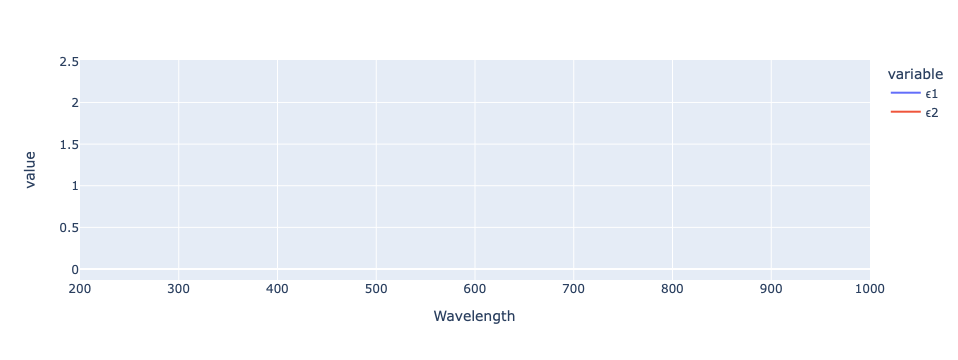

In [25]:
fitted_model = elli.Cauchy(
        fit_stats.params["SiO2_n0"],
        fit_stats.params["SiO2_n1"],
        fit_stats.params["SiO2_n2"],
        fit_stats.params["SiO2_k0"],
        fit_stats.params["SiO2_k1"],
        fit_stats.params["SiO2_k2"],
    )

fitted_model.get_dielectric_df().plot(backend='plotly')

We can also call `get_refractive_index_df()` to get the refractive index of the material as dataframe.

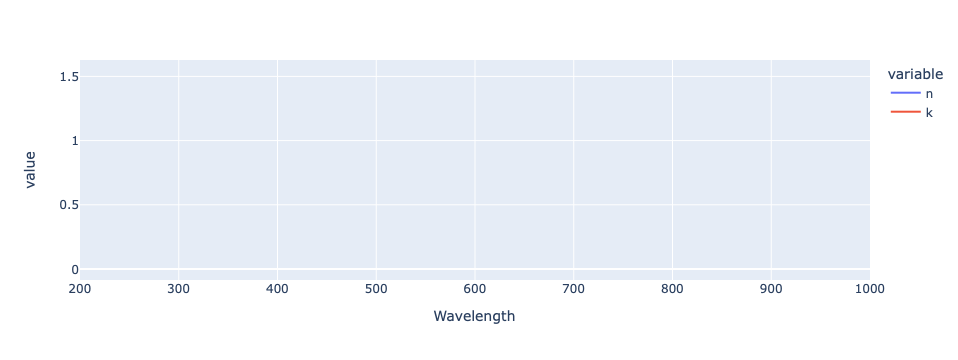

In [26]:
fitted_model.get_refractive_index_df().plot(backend='plotly')

If you want to write your data to a file you simply call pandas `to_csv(...)` function to write a csv file, i.e. for the dielectric function this writes as

In [27]:
fitted_model.get_dielectric_df().to_csv('SiO2_diel_func.csv')

You may also access a single value of your optical model

In [7]:
fit_stats.params['SiO2_n0'].value

1.981575264531358

Our simply print the fitted values in a list together with their fitting errors

In [39]:
fit_stats.params

name,value,standard error,relative error,initial value,min,max,vary
SiO2_n0,1.45200000,0.00000000,(0.00%),1.452,-100.000000,100.000000,False
SiO2_n1,36.0000000,0.00000000,(0.00%),36.0,-40000.0000,40000.0000,False
SiO2_n2,0.00000000,0.00000000,,0,-40000.0000,40000.0000,False
SiO2_k0,0.00000000,0.00000000,,0,-100.000000,100.000000,False
SiO2_k1,0.00000000,0.00000000,,0,-40000.0000,40000.0000,False
SiO2_k2,0.00000000,0.00000000,,0,-40000.0000,40000.0000,False
SiO2_d,2.07022134,0.00714228,(0.35%),20,0.00000000,40000.0000,True


### 3.6 Show fit statistics
Now, we may also print out the fit statictics from the model fit in the cell above. The fit statistics are simple [lmfit fit statistics](https://lmfit.github.io/lmfit-py/fitting.html#), too. Typically, one uses chi square values as a figure of merit for the fit quality. It is stored in the `chisqr` attribute of the `fit_stats` variable we defined in 3.4.

In [21]:
fit_stats.chisqr

0.008373775114143998

We can print the full fit statistics, too.

In [23]:
fit_stats